# homework 05: a mixture of five
* Eric Yang
* 10/11/2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand
import math
import scipy.stats as stats
import scipy.special as special
from collections import Counter

In [2]:
# read in file, adopted from w05-visualize.py
def read_data(infile):
    '''
    read_data(infile)
    Read Lestrade's input file, w05-data.tbl, or a file in that format.
    Return:
       ctype[0..N-1] : cell types 0..Q-1 for each cell i
       data[i,g]     : array of count data; rows = cells i; cols = genes g
       N             : number of cells (rows of the data file)
       G             : number of genes (cols of the data file, after the first)
       Q             : number of cell types
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

In [3]:
# read in file
ctype, data, N, G, Q = read_data('w05-data.tbl')

1. reproduce Wiggins' K-means result

In [4]:
def k_means(points, k, n_runs):
    '''
    performs k-means clustering on given 2D datapoints (caraway, kiwi)
    k specifies number of clusters 
    n_runs specifies number of runs
    result is a cluster plot that shows the best result based on minimum total distance from all points to assigned centroids
    '''
    # initialize best clusters
    min_dist = float('inf')
    best_clusters = []
    
    # split points into caraways and kiwis
    caraway = [i[0] for i in data]
    kiwi = [i[1] for i in data]
    
    for run in range(n_runs):
        # initialize random set of centers based on max and min of 2D points
        centroids = []
        for i in range(k):
            centroids.append([np.random.choice(np.linspace(min(caraway), max(caraway), 100)),
                            np.random.choice(np.linspace(min(kiwi), max(kiwi), 100))]) 
        
        # initialize clusters
        clusters_prev = []*len(points)
        clusters = [0]*len(points)
        
        # stop when clusters don't change
        while clusters_prev != clusters:
            clusters_prev = clusters
            # assign clusters
            clusters,distance = assign_clusters(points, centroids)
            # update centroids
            centroids = update_centroids(points, clusters, k)
            
        # save best clusters, centers and min_dist
        if distance < min_dist:
            best_clusters = clusters
            best_centroids = centroids
            min_dist = distance

    # plot data
    plot_clusters(points, best_clusters, best_centroids)      

In [5]:
def assign_clusters(points, centroids):
    '''
    assigns each point to the closest centroid, distance defined by euclidean distance
    returns assigned cluster for each point and total squared distance
    '''
    # assign clusters
    clusters = [] # int list of length len(points)
    distances = [] # float list of length len(points)
    for point in points:
        dist_to_centroids = [] 
        for centroid in centroids:
            dist = math.sqrt((point[0]-centroid[0])**2 + (point[1]-centroid[1])**2)
            dist_to_centroids.append(dist)
        clusters.append(np.argmin(dist_to_centroids))
        distances.append(np.min(dist_to_centroids))
    
    # dictionary mapping cluster to number of points in that cluster
    counts = Counter(clusters)
    
    # check for empty clusters, assign those with assign_empty helper function
    for cluster in range(len(centroids)):
        if cluster not in counts.keys():
            clusters, distances = assign_empty(cluster, clusters, distances)

    return clusters, sum(distances)

In [6]:
def assign_empty(empty_cluster, clusters, distances):
    '''
    assigns empty clusters to a point that is farthest away from any cluster
    updates clusters and distances lists
    '''
    # find point farthest away from any cluster
    idx = np.argmax(distances)
    
    # assign empty cluster to that point
    clusters[idx] = empty_cluster
    
    # set distance for that point to 0 since it is on a cluster
    distances[idx] = 0
    
    return clusters, distances

In [7]:
def update_centroids(points, clusters, k):
    '''
    updates centroids as mean of all the points assigned to that cluster
    k is number of clusters
    '''
    points = np.asarray(points)
    clusters = np.asarray(clusters)
    
    # get indexes of each point assigned to each cluster
    cluster_indexes = [] # each item inside the list is a list of indexes
    for cluster in range(k):
        cluster_indexes.append(np.where(clusters == cluster))
    
    # find new centroid for each cluster by average (caraway, kiwi)
    centroids = []
    for cluster in range(k):
        centroids.append(np.mean(points[cluster_indexes[cluster]],axis=0))
    
    return centroids

In [8]:
# adapted from w05-visualize.py
def plot_clusters(points, clusters, centroids):
    
    N, G  = np.shape(data)
    Q, G2 = np.shape(centroids)
    centroids = np.asarray(centroids)
    
    # assign colors
    colormap = ['xkcd:mustard', 'xkcd:rose','xkcd:olive','xkcd:azure','xkcd:orange']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[clusters[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog(points[i,0], points[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(centroids[q,0], centroids[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

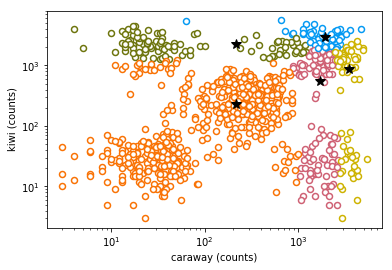

In [9]:
k_means(data, 5, 20)

Why is K-means clustering producing this result, when there are clearly five distinct clusters in the data?

There does not seem to be anything wrong with the k-means implementation. It seems like the issue is that the 5 clusters exist in logspace, while the cluster assignments in k-means are done in standard euclidean space. I will explore a solution towards this in part 3.

2. mixture negative binomial fitting

In [10]:
# partially adapted from w05-section_jupyter_notebook.ipynb
def negative_binomial_em(points, k, n_runs, nll_thresh):
    '''
    performs expectation maximization with negative binomial to cluster cells given 2D gene datapoints (caraway, kiwi)
    k specifies number of clusters 
    n_runs specifies number of runs
    nll_thresh determines when to stop clustering iteration for each run
    result is a cluster plot that shows the best result based on minimum negative log likelihood of data given mixture models
    returns means of all clusters, and number of datapoints in each cluster
    '''
    
    # define best mus (mus_best), best distance to mu (min_dist), best mixture coefficients (mix_coeffs_best
    # and intialize as starting best nll (nll_best) 
    min_dist = float('inf')
    mus_best = []*len(points)
    nll_best = float('inf')
    mix_coeffs_best = []
    
    # split points into caraways and kiwis
    caraway = [i[0] for i in data]
    kiwi = [i[1] for i in data]
    
    for i in range(n_runs):
        # Each iteration starts with a random set of mus (mus) with random mixture coeffcients (mix_coeffs)
        mix_coeffs = rand.rand(k)
        mix_coeffs = np.divide(mix_coeffs,sum(mix_coeffs))
        mus = []
        for i in range(k):
            mus.append([np.random.choice(np.linspace(min(caraway), max(caraway), 100)),
                            np.random.choice(np.linspace(min(kiwi), max(kiwi), 100))]) 
            
        # We will iterate until the nll_diff <= (nll_thresh* nll_old)
        # Here we initialize holder variables for the last nll and the difference between the current and last nll
        nll_diff = float('inf')
        nll_old = float(0)    
        
        # Iterate while the differnece between consecutive nlls is above a threshold
        while nll_diff > (nll_thresh* nll_old):
        
            # Calculate posterior probabilities and assign points to clusters
            posts,clusters = expectation(points, mus, 0.3, mix_coeffs) # phi = 0.3
            
            # Calculate new mus and mixture coefficients given current posterior probabilities
            mus, mix_coeffs = maximization(points, posts, mix_coeffs)    
            
            # Calcualte the nll of the current mixture model
            nll = negll(points, mus, 0.3, mix_coeffs) # phi = 0.3
            
            # find difference in consecutive nlls and update the nll_old
            nll_diff = abs(nll-nll_old)
            nll_old = nll
            
        # Update best estimates for mus, mixture coefficients and cluster assignments
        if nll < nll_best:
            mix_coeffs_best = mix_coeffs
            nll_best = nll
            mus_best = mus
            clusters_best = clusters
        
    # plot data
    plot_clusters(points, clusters_best, mus_best)    
    
    return mus_best, Counter(clusters_best)

In [11]:
# partially adapted from w05-section_jupyter_notebook.ipynb
def expectation(points, mus, phi, pis):
    '''
    calculates posterior prob of point belonging to each component
    assigns each point to a cluster based on max posterior prob
    
    Inputs:
    points        : list or 1D array, (caraway,kiwi) of all points
    mus           : list or 1D array, current estimates for component means
    phi           : float, set parameter for component distribution
    pis           : list or 1D array, current extiamtes for mixture coefficients of components
    
    Returns
    -------
    posts    : 2D array, Posterior probabilities of each component being the source of each point.
    clusters : list or 1D array, list of current cluster assignment for each point 
    '''
    
    # initialize P(q|x)
    Pqx = [] # each row is a point, each column is a component
    
    # scipy.stats.nbinom.pmf takes in n, p
    n = 1/phi
    p = 1/(1+np.array(mus)*phi)
    
    # get posterior probs with negative binomial distribution for each component of each point
    for point in points:
        point_prob = []
        for idx, mu in enumerate(mus):
            prob = stats.nbinom.pmf(point[0],n,p[idx,0]) * stats.nbinom.pmf(point[1],n,p[idx,1])
            point_prob.append(prob)
        Pqx.append(point_prob)
    
    # normalize so that probs of each point sum to 1
    posts = []
    for point in Pqx:
        total_prob = sum(point)
        post = [x / total_prob for x in point]
        posts.append(post)
    
    # assign each point to cluster
    clusters = []
    for point in posts:
        clusters.append(np.argmax(point))
        
    return posts, clusters

In [12]:
# partially adapted from w05-section_jupyter_notebook.ipynb
def maximization(points, posts, pis):
    '''
    Return the updated mu and pi for each component
    
    Parameters
    ----------
    points        : list or 1D array, (caraway,kiwi) of all points
    posts         : 2D array, Posterior probabilities of each component being the source of each point
    pis           : list or 1D array, list of current extiamtes for mixture coefficients of components
    
    Returns
    -------
    mus           : list or 1D array, current estimate of component means
    new_pis       : list or 1D array, updated list of extimates for mixture coefficients of components 
    '''
    
    # convert to np array for mathematical manipulation of 2D lists
    points = np.array(points)
    posts = np.array(posts)
    
    # calculate the new mean for each component q as the posterior weighted average of point positions 
    # each column represents a component in our matrix of posterior probabilities (posts)
    mus = []
    denominators = []
    for k in range(len(pis)):    
        numerator = 0
        denominator = 0
        for idx, point in enumerate(points):
            numerator += np.array(point) * posts[idx, k]
            denominator += posts[idx, k]
        mus.append((numerator/denominator).tolist())
        denominators.append(denominator)
    
    # calculate the new mixture coefficients as the mean of the posteriors
    # the updated mixture coefficients π are the expected fraction of data points assigned to each component 
    new_pis = np.array(denominators)/len(points)
    
    return mus, new_pis.tolist()

In [13]:
# partiallly adapted from w05-section_jupyter_notebook.ipynb
def negll(points, mus, phi, pis):
    '''
    Return the negative log likelihood of data given the current mixture model
    
    Inputs:
    points        : list or 1D array, (caraway,kiwi) of all points
    mus           : list or 1D array, current estimates for component means
    phi           : float, set parameter for component distribution
    pis           : list or 1D array, current extiamtes for mixture coefficients of components
    
    Returns
    -------
    nll       : float, negative log likelihood of data given model
    '''
    # scipy.stats.nbinom.pmf takes in n, p
    n = 1/phi
    p = 1/(1+np.array(mus)*phi)
    
    # Compute the nll as the normal logpdf of the data, given mu and sigma, plus the log of the mixture coefficient
    # Summed for each point
    denominators = []
    for point in points:
        prob = []
        for idx, mu in enumerate(mus):
            prob.append(np.log10(pis[idx]) + stats.nbinom.logpmf(point[0],n,p[idx,0]) + stats.nbinom.logpmf(point[1],n,p[idx,1]))
        denominators.append(special.logsumexp(prob))
    
    return -sum(denominators)

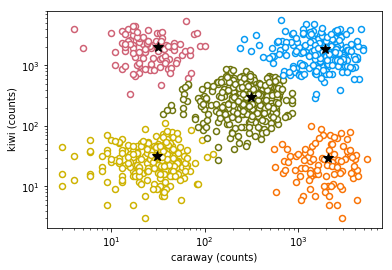

In [14]:
means, counts = negative_binomial_em(data, 5, n_runs=10, nll_thresh=0.001)

In [15]:
print(means)

[[31.25375023362203, 31.471399762162047], [31.356562481173782, 1996.102152635695], [310.39429822282773, 305.6904912989018], [1920.2094776803076, 1865.6192992250262], [2054.5078857455155, 29.27850377114431]]


In [16]:
print(counts)

Counter({2: 373, 0: 220, 3: 204, 1: 106, 4: 97})


* Note that these results may be slightly different each run of the notebook due to random initial assignment
The estimated mean expression levels of (Caraway, Kiwi) with count as units are:
1. (1920.2, 1865.6)
2. (31.3, 31.5)
3. (31.4, 1996.0)
4. (310.4, 305.6)
5. (2055.5, 29.3)

For each of the above clusters, the relative proportions of each cell type in the 1000 cells are:
1. 0.204
2. 0.22
3. 0.106
4. 0.373
5. 0.097

3. find a simple fix for K-means

As noted above, the clusters exist in logspace while the cluster assignments are done in standard euclidean space. There are several ways to address this, one of which involves simply transforming the data into logspace before performing k-means. This allows standard euclidean distance calculations to reveal clusters in the logspace.

In [19]:
def k_means_fix(points, k, n_runs):
    '''
    performs k-means clustering on given 2D datapoints (caraway, kiwi), addresses clusters that exist in logspace
    k specifies number of clusters 
    n_runs specifies number of runs
    result is a cluster plot that shows the best result based on minimum total distance from all points to assigned centroids
    '''
    points = np.log10(points)
    # initialize best clusters
    min_dist = float('inf')
    best_clusters = []
    
    # split points into caraways and kiwis
    caraway = [i[0] for i in data]
    kiwi = [i[1] for i in data]
    
    for run in range(n_runs):
        # initialize random set of centers based on max and min of 2D points in logspace
        centroids = []
        for i in range(k):
            centroids.append([np.random.choice(np.linspace(min(caraway), max(caraway), 100)),
                            np.random.choice(np.linspace(min(kiwi), max(kiwi), 100))]) 
        # initialize clusters
        clusters_prev = []*len(points)
        clusters = [0]*len(points)
        
        # stop when clusters don't change
        while clusters_prev != clusters:
            clusters_prev = clusters
            # assign clusters
            clusters,distance = assign_clusters(points, centroids)
            # update centroids
            centroids = update_centroids(points, clusters, k)
            
        # save best clusters, centers and min_dist
        if distance < min_dist:
            best_clusters = clusters
            best_centroids = centroids
            min_dist = distance

    # plot data
    plot_clusters(points, best_clusters, best_centroids)      

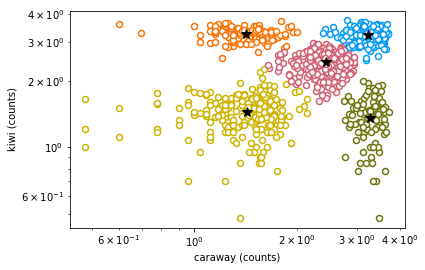

In [20]:
k_means_fix(data, 5, 20)